# Imports

In [40]:
import pandas as pd
import quandl
import math
import numpy as np
from sklearn import preprocessing, svm
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.pyplot as plt
from matplotlib import style
import pickle

# Data import and preprocessing

In [2]:
quandl.ApiConfig.api_key = 'TznotdWT9T1tGPdFuRdZ'

In [3]:
df = quandl.get('WIKI/GOOGL')

In [4]:
df.head()

,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
Date,,,,,,,,,,,,
2004-08-19,100.01,104.06,95.96,100.335,44659000.0,0.0,1.0,50.159839,52.191109,48.128568,50.322842,44659000.0
2004-08-20,101.01,109.08,100.50,108.310,22834300.0,0.0,1.0,50.661387,54.708881,50.405597,54.322689,22834300.0
2004-08-23,110.76,113.48,109.05,109.400,18256100.0,0.0,1.0,55.551482,56.915693,54.693835,54.869377,18256100.0
2004-08-24,111.24,111.60,103.57,104.870,15247300.0,0.0,1.0,55.792225,55.972783,51.945350,52.597363,15247300.0
2004-08-25,104.76,108.00,103.88,106.000,9188600.0,0.0,1.0,52.542193,54.167209,52.100830,53.164113,9188600.0


You want features, but you need meaningful features, which actually bring info to our regression model.
You need to simplify your data as much as possible. Useless, correlated features can cause more problems than bring info.

In [5]:
df = df[['Adj. Open','Adj. High','Adj. Low','Adj. Close'
         ,'Adj. Volume']]

We want to keep features that have a meaningful relantionship. E.g.: Adj. High & Adj. Low tells us something about the volatility of the market that day. And, we wan to drop features that don't bring additional info.

In [6]:
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low']) / df['Adj. Close'] * 100.0
df['PCT_change'] = (df['Adj. Close'] - df['Adj. Open']) / df['Adj. Open'] * 100.0

In [7]:
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume']]

In [8]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume
Date,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0
2004-08-20,54.322689,7.921706,7.227007,22834300.0
2004-08-23,54.869377,4.049360,-1.227880,18256100.0
2004-08-24,52.597363,7.657099,-5.726357,15247300.0
2004-08-25,53.164113,3.886792,1.183658,9188600.0


Features are like attributes that make up the labels, and labels are like predictions.

So, which column is the label and which are the features?

Adj. Close can be feature or none of the above. It could be a label if we had chosen other features b/c we wouldn't know the High - Low or percent change until the close had already occured. 

If you trained an algorithm to predict that value, it would be very biased.

What we'll do is take the last 10 values of Adj. and try to predict another value. Close and that's a feature, but that's for when we write the algorithm ourselves.

A label will be a future price, and the only column that fits is Adj. Price, but it's for the next day or for the next 5 days.

In [9]:
forecast_col = 'Adj. Close'

We can't use empty rows in ML, so we need to fill NaN's. The below method will treat such rows, examples as outliers.

In [10]:
df.fillna(-99999, inplace = True)

We try to predict out 10% of the dataframe. In reality, we get tomorrow's price, and next day's price. We're using data that came 10 days ago to predict today.

Float var can be played with.

In [11]:
forecast_out = int(math.ceil(0.01*len(df)))

We define the label and shifting the "rows" negatively, so up. This way each row's label column will be the Adjusted Close price 10 days into the future.

Our features are these attributes that, we consider, may cause the adjusted close price in 10 days to change. Actually, it's 10% of the timeframe.

In [12]:
df['label'] = df[forecast_col].shift(-forecast_out)

In [13]:
df.head()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label
Date,,,,,
2004-08-19,50.322842,8.072956,0.324968,44659000.0,69.078238
2004-08-20,54.322689,7.921706,7.227007,22834300.0,67.839414
2004-08-23,54.869377,4.049360,-1.227880,18256100.0,68.912727
2004-08-24,52.597363,7.657099,-5.726357,15247300.0,70.668146
2004-08-25,53.164113,3.886792,1.183658,9188600.0,71.219849


# Training the Learning Algorithm

In [14]:
X = np.array(df.drop(['label'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:] #for making the actual predictions, don't have y label
X = X[:-forecast_out]

In [15]:
df.dropna(inplace=True)
y = np.array(df['label'])

In [16]:
X.shape

(3389, 4)

In [17]:
y.shape

(3389,)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

**Using Linear Regression model**

In [19]:
clf = LinearRegression()

In [20]:
clf.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [21]:
accuracy = clf.score(X_test, y_test)
accuracy

0.977914338368261

In [22]:
print(forecast_out)

35


The accuracy is 97.7% for approx. 34 days in advance.

Caveats:

* Accuracy for Linear Regression is the mean squared error.
* It is *very high* for 34 days in advance using a simple module. Clearly, stock is more difficult to predict than this.
* Because the accuracy is defined as above, it's more like saying it's directionall accurate.

**Using Support Vector Machine's Regression model**

In [23]:
clf = svm.SVR()

In [24]:
clf.fit(X_train, y_train)

C:\Users\inastasa\AppData\Local\Continuum\Anaconda3\envs\ionut-env\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [41]:
with open('linearregression.pickle', 'wb') as f:
    pickle.dump(clf, f)

#to use the pickled model we do the following:
pickle_in = open('linearregression.pickle', 'rb')
clf = pickle.load(pickle_in)

In [42]:
accuracy = clf.score(X_test, y_test)
accuracy

0.811154007961913

The SVM model is a lot more inaccurate.

# Making Predictions

In [29]:
forecast_set = clf.predict(X_lately)

In [31]:
print(forecast_set, accuracy, forecast_out)

[366.6942506  493.03482896 368.13057023 412.38039    691.80430458
 699.67919448 592.52585323 636.43685856 682.15834749 625.27719916
 626.0122571  647.63810472 642.93530224 630.0694888  528.12427403
 589.63896935 417.7402096  485.72972911 583.77090566 672.51094764
 557.8288014  634.88415359 553.10957808 641.40014503 443.01340289
 651.61807498 625.28850144 562.59405262 565.50694394 662.97013118
 673.35799343 496.52447577 463.52121751 468.45885903 363.70450844] 0.811154007961913 35


**Plotting the Forecasts**

In [33]:
style.use('ggplot')

In [34]:
df['Forecast'] = np.nan

In [35]:
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

Iterating through the forecast taking each forecast and day, setting them as values in the dataframe, therefore making the future features NaN's. 

Last line takes all the columns and sets them to NaN's.

In [36]:
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += one_day
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)] + [i]

In [39]:
df.tail()

,Adj. Close,HL_PCT,PCT_change,Adj. Volume,label,Forecast
Date,,,,,,
2018-03-08 02:00:00,NaN,NaN,NaN,NaN,NaN,673.357993
2018-03-09 02:00:00,NaN,NaN,NaN,NaN,NaN,496.524476
2018-03-10 02:00:00,NaN,NaN,NaN,NaN,NaN,463.521218
2018-03-11 02:00:00,NaN,NaN,NaN,NaN,NaN,468.458859
2018-03-12 02:00:00,NaN,NaN,NaN,NaN,NaN,363.704508


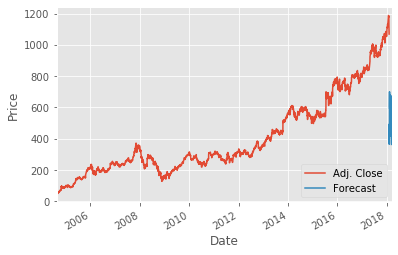

In [37]:
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc = 4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Pickling

Pickling is serialization of any Python object (e.g.: dictionary, classifier, etc.). Works similarly to a file: you open it, save it and when you need it again, you open it and use it.

When should we pickle our model? We want to save time spent on training the algorithm, especially if we train it on a very large set.

So, we're going to pickle our model above right after fitting it.